Notebook Author: Ayana Andrews-Joseph\
**Data**: Pet Supplies Reviews from [Amazon product data](http://jmcauley.ucsd.edu/data/amazon/)\
**Provider**: Julian McAuley, USCD\
**Description**: This dataset contains product reviews and metadata from Amazon, including 142.8 million reviews spanning May 1996 - July 2014.\
This dataset includes reviews (ratings, text, helpfulness votes), product metadata (descriptions, category information, price, brand, and image features), and links (also viewed/also bought graphs).\
**5-core**: Subset of the data in which all users and items have at least 5 reviews.\
**Format**: one-review-per-lline in (loose) json.\

**Definitions**: 
> **reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B \
> **asin** - ID of the product, e.g. 0000013714 \
> **reviewerName** - name of the reviewer \
> **helpful** - helpfulness rating of the review, e.g. 2/3 \
> **reviewText** - text of the review \
> **overall** - rating of the product \
> **summary** - summary of the review \
> **unixReviewTime** - time of the review (unix time) \
> **reviewTime** - time of the review (raw) 

**NOTE**: Selected a *“Small” subset for experimentation*, which uses `K-cores`. These data have been reduced to extract the k-core, such that each of the remaining users and items have k reviews each. (McAuley) The concept of a k-core was introduced to study the clustering structure of social networks and to describe the evolution of random graphs.

# Dataset

In [1]:
pip install ijson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 318.8 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data Manipulation & Visualization
import os
import pandas as pd
import numpy as np
import ijson
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns # used for plot interactive graph. 
sns.set_style('darkgrid')

# Text Manipulation
from textblob import TextBlob # text processing
from textblob import Blobber
import nltk
nltk.download('all') # Download stopwords list, updated lemmatizer, tokenizers, etc.
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.wordnet import WordNetLemmatizer 



[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /usr/share/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /usr/share/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /usr/share/nltk_data...


In [3]:
# read in data
rawDat = pd.read_json("../input/amzn-reviews-pet-supplies/Pet_Supplies_5.json",
                        lines=True,
                        orient="columns")
print(rawDat.shape)
rawDat.head()

(157836, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A14CK12J7C7JRK,1223000893,Consumer in NorCal,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes,1294790400,"01 12, 2011"
1,A39QHP5WLON5HV,1223000893,Melodee Placial,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats,1379116800,"09 14, 2013"
2,A2CR37UY3VR7BN,1223000893,Michelle Ashbery,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining,1355875200,"12 19, 2012"
3,A2A4COGL9VW2HY,1223000893,Michelle P,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them,1305158400,"05 12, 2011"
4,A2UBQA85NIGLHA,1223000893,"Tim Isenhour ""Timbo""","[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2,1330905600,"03 5, 2012"


In [4]:
df = rawDat[["helpful", "reviewText", "overall", "summary"]]

df.head()

,helpful,reviewText,overall,summary
0,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,Nice Distraction for my cats for about 15 minutes
1,"[0, 0]",There are usually one or more of my cats watch...,5,Entertaining for my cats
2,"[0, 0]",I bought the triliogy and have tested out all ...,4,Entertaining
3,"[2, 2]",My female kitty could care less about these vi...,4,Happy to have them
4,"[6, 7]","If I had gotten just volume two, I would have ...",3,You really only need vol 2


# Overall Rating Distribution

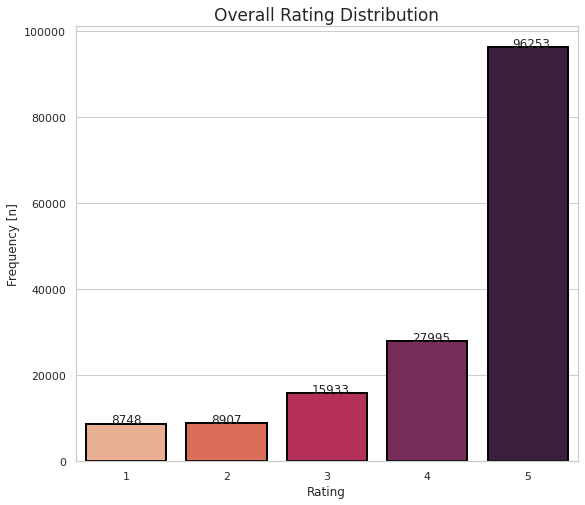

In [5]:
plt.figure(figsize=(9,8))
sns.set_theme(style="whitegrid")
ax = sns.countplot(data=df, x="overall", edgecolor='black', linewidth=2, palette=("rocket_r"))
plt.title("Overall Rating Distribution", size = 17)
plt.xlabel('Rating')
plt.ylabel('Frequency [n]')

for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.75))

plt.show()

### The overall rating distribution is "left-skewed", there are more 5-star ratings in comparison to the entire dataset.

## Get column integer location

In [6]:
df.columns.get_loc('summary')

3

## Convert comment text to lower() for text processing

In [7]:
# Set clean data to lowercase for stopwords preprocessing
df['summary'] = df['summary'].str.lower()
df['summary'].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0    nice distraction for my cats for about 15 minutes
1                             entertaining for my cats
2                                         entertaining
3                                   happy to have them
4                           you really only need vol 2
Name: summary, dtype: object

## Apply `stopwords` 
Although the data set is relatively clean, we can apply stop words for further processing (words that do not count in linguistic analysis). The most common SEO stop words are pronouns, articles, prepositions, and conjunctions.

In [8]:
# datacheck for stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
stop = stopwords.words('english') 

# apply stopwords
df['clean_text'] = df['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,helpful,reviewText,overall,summary,clean_text
0,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,nice distraction for my cats for about 15 minutes,nice distraction cats 15 minutes
1,"[0, 0]",There are usually one or more of my cats watch...,5,entertaining for my cats,entertaining cats
2,"[0, 0]",I bought the triliogy and have tested out all ...,4,entertaining,entertaining
3,"[2, 2]",My female kitty could care less about these vi...,4,happy to have them,happy
4,"[6, 7]","If I had gotten just volume two, I would have ...",3,you really only need vol 2,really need vol 2


In [10]:
df.clean_text.head()

0    nice distraction cats 15 minutes
1                   entertaining cats
2                        entertaining
3                               happy
4                   really need vol 2
Name: clean_text, dtype: object

### Tokenization and Lemmatization

In [11]:
# Init tokenizer and Lemmatizer
w_token = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_token.tokenize(text)]

df['text_lemma'] = df['clean_text'].apply(lemmatize_text)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
df.head(30)

,helpful,reviewText,overall,summary,clean_text,text_lemma
0,"[0, 0]",I purchased the Trilogy with hoping my two cat...,3,nice distraction for my cats for about 15 minutes,nice distraction cats 15 minutes,"[nice, distraction, cat, 15, minute]"
1,"[0, 0]",There are usually one or more of my cats watch...,5,entertaining for my cats,entertaining cats,"[entertaining, cat]"
2,"[0, 0]",I bought the triliogy and have tested out all ...,4,entertaining,entertaining,[entertaining]
3,"[2, 2]",My female kitty could care less about these vi...,4,happy to have them,happy,[happy]
4,"[6, 7]","If I had gotten just volume two, I would have ...",3,you really only need vol 2,really need vol 2,"[really, need, vol, 2]"
5,"[10, 10]","My Rottie has food allergies to poultry, beef ...",5,great for pups with food allergies,great pups food allergies,"[great, pup, food, allergy]"
6,"[2, 2]",My puppy loves this stuff! His tail starts wag...,5,naturally yummy!,naturally yummy!,"[naturally, yummy!]"
7,"[2, 2]",My toy poodle loves this stuff and will let me...,4,bought to help with dog breath,bought help dog breath,"[bought, help, dog, breath]"
8,"[0, 0]",Works great and dog doesn't hate the taste. G...,5,brushing those teeth isn't so hard with this d...,brushing teeth hard dog toothpaste,"[brushing, teeth, hard, dog, toothpaste]"
9,"[1, 1]","Yes , my Princess is enjoying the taste showin...",5,good product ...,good product ...,"[good, product, ...]"
